# Deep Reinforcement Learning
In this lab we will implement and train an agent that uses deep learning to play balance the stick in `CartPole-v1`.

## Setup
----
We import useful packages: `gym`, `torch` stuff, etc..

Imports:

In [22]:
import gym

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib as plt

from collections import deque  # for memory
from tqdm import tqdm          # for progress bar
import numpy as np

from copy import deepcopy
import random
from turtle import done, st


How the game looks (without our agent):

In [23]:
"""env = gym.make('CartPole-v1', render_mode='human')
for _ in tqdm(range(10)):
    state, _ = env.reset()
    done = False
    while not done:
        action = env.action_space.sample()
        next_state, reward, done, _, _ = env.step(action)
env.close()"""

"env = gym.make('CartPole-v1', render_mode='human')\nfor _ in tqdm(range(10)):\n    state, _ = env.reset()\n    done = False\n    while not done:\n        action = env.action_space.sample()\n        next_state, reward, done, _, _ = env.step(action)\nenv.close()"

## DQN Algorithm
-------------
We train a policy that tries to maximize the discounted,
cumulative reward
$R_{t_0} = \sum_{t=t_0}^{\infty} \gamma^{t - t_0} r_t$, where
$R_{t_0}$ is *return*. The discount, $\gamma$ is the discount, between $0$ and $1$


Q-learning tries to find a function
$Q^*: State \times Action \rightarrow \mathbb{R}$, maximizes rewards:

$\begin{align}\pi^*(s) = \arg\!\max_a \ Q^*(s, a)\end{align}$

However, we don't know $Q^*$. So, we use neural network as a approximators, we can simply create one and train it to resemble $Q^*$.

For our training update rule, we'll use a fact that every $Q$
function for some policy obeys the Bellman equation:

$\begin{align}Q^{\pi}(s, a) = r + \gamma Q^{\pi}(s', \pi(s'))\end{align}$

The difference between the two sides of the equality is known as the temporal difference error, $\delta$:

$\begin{align}\delta = Q(s, a) - (r + \gamma \max_a Q(s', a))\end{align}$

### Model
---
Make a deep learning based policy model, that takes in a state and outputs an action.
This model will be an attribute of the Agent we make next.

In [24]:
class Model(nn.Module):
    def __init__(self, observation_size, action_size):
        super(Model, self).__init__()
        self.dense1 = nn.Linear(observation_size, 100)

        self.dense2 = nn.Linear(100, 100)
        self.dense3 = nn.Linear(100, 100)
        # had to hardcode it to 4 becuse action_size is 2
        self.dense4 = nn.Linear(100, action_size)

        torch.nn.init.xavier_uniform_(self.dense1.weight)
        torch.nn.init.xavier_uniform_(self.dense2.weight)
        torch.nn.init.xavier_uniform_(self.dense3.weight)
        torch.nn.init.xavier_uniform_(self.dense4.weight)

    def forward(self, x):
        x = self.dense1(x)
        x = F.relu(x)
        x = self.dense2(x)
        x = F.relu(x)
        x = self.dense3(x)
        x = F.relu(x)
        x = self.dense4(x)
        return x

    def predict(self, x):
        x = torch.tensor(x)
        x = self.forward(x)

        return torch.argmax(x)


### DQN Agent
----
We will be using experience replay memory for training our model.
An Agent's memory is as important as its model, and will be another attribute of our agent.
Other appropriate attributes are the hyperparameters (gamma, lr, etc.).
Give the agent a replay method that trains on a batch from its memory.


In [25]:
"""env = gym.make('CartPole-v1')
state, _ = env.reset()"""


"env = gym.make('CartPole-v1')\nstate, _ = env.reset()"

In [26]:
class Agent:
    def __init__(self, observation_size, action_size):
        self.observation_size = observation_size
        self.action_size = action_size
        self.criterion = nn.MSELoss()
        self.model = Model(observation_size, action_size)
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-3)
        # memory that stores N most new transitions
        self.memory = deque([], maxlen=2000)
        self.epsilon = 1.0
        self.decay_rate = 0.99
        # good place to store hyperparameters as attributes

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        rand = random.uniform(0, 1)
        if rand > self.epsilon:
            return int(self.model.predict(state))
        else:
            return int(env.action_space.sample())
    
    def act_optimal(self,state):
        return int(self.model.predict(state))

    def replay(self, batch_size):
        # update model based on replay memory
        # you might want to make a self.train() helper method
        transition_set = random.sample(self.memory, batch_size)
        self.optimizer.zero_grad()

        for transition in transition_set:
            self.train(transition)

        self.epsilon *= self.decay_rate
        self.optimizer.step()

    def train(self, data_set):
        state = torch.tensor(data_set[0])
        action = torch.tensor(data_set[1])
        reward = torch.tensor(data_set[2])
        next_state = torch.tensor(data_set[3])
        done = torch.tensor(data_set[4])
        gamma = 0.9

        new_reward = reward

        if not done:
            new_reward = reward + gamma * \
                float(torch.max(self.model.forward(next_state)))

        prediction = self.model.forward(state)[action]
        loss = self.criterion(prediction, new_reward)
        loss.backward()


### Main Training loop
---
Make a function that takes and environment and an agent, and runs through $n$ episodes.
Remember to call that agent's replay function to learn from its past (once it has a past).


In [27]:
import pickle
import matplotlib.pyplot as plt
filename_out = '5 - DRL_200_v2.txt'
ys = []

def train(envrioment, agent: Agent, episodes=200, batch_size=64):  # train for many games
    for e in tqdm(range(episodes)):

        if e % 10 == 0:
            file = open(filename_out, 'wb')
            pickle.dump(agent.model, file)
            file.close()
            print("save")

        state, _ = envrioment.reset()
        done = False
        total_r = 0
        while not done:
            # 1. make a move in game.
            action = agent.act(state)
            # 2. have the agent remember stuff.
            next_state, reward, done, _, _ = envrioment.step(action)
            total_r += reward
            agent.remember(state, action, reward, next_state, done)
            # 3. update state
            state = next_state
            # 4. if we have enough experiences in out memory, learn from a batch with replay.
            if len(agent.memory) >= batch_size:
                agent.replay(batch_size)
        ys.append(total_r)
    envrioment.close()
    plt.plot(ys)


### Putting it together
---
We train an agent on the environment:


  0%|          | 0/200 [00:00<?, ?it/s]

save


  5%|▌         | 10/200 [00:05<02:27,  1.29it/s]

save


 10%|█         | 20/200 [01:44<32:32, 10.85s/it]

save


 15%|█▌        | 30/200 [03:35<30:24, 10.73s/it]

save


 20%|██        | 40/200 [04:45<23:14,  8.72s/it]

save


 25%|██▌       | 50/200 [05:59<15:00,  6.01s/it]

save


 30%|███       | 60/200 [07:02<17:01,  7.30s/it]

save


 35%|███▌      | 70/200 [08:10<15:34,  7.19s/it]

save


 40%|████      | 80/200 [09:13<12:30,  6.26s/it]

save


 45%|████▌     | 90/200 [10:33<15:25,  8.41s/it]

save


 50%|█████     | 100/200 [11:49<11:15,  6.76s/it]

save


 55%|█████▌    | 110/200 [12:51<06:42,  4.47s/it]

save


 60%|██████    | 120/200 [13:47<08:57,  6.72s/it]

save


 65%|██████▌   | 130/200 [15:06<09:05,  7.79s/it]

save


 70%|███████   | 140/200 [16:20<07:42,  7.71s/it]

save


 75%|███████▌  | 150/200 [18:29<09:15, 11.11s/it]

save


 80%|████████  | 160/200 [19:38<05:16,  7.90s/it]

save


 85%|████████▌ | 170/200 [20:44<03:20,  6.68s/it]

save


 90%|█████████ | 180/200 [21:48<02:37,  7.88s/it]

save


 95%|█████████▌| 190/200 [23:09<01:24,  8.47s/it]

save


100%|██████████| 200/200 [24:32<00:00,  7.36s/it]


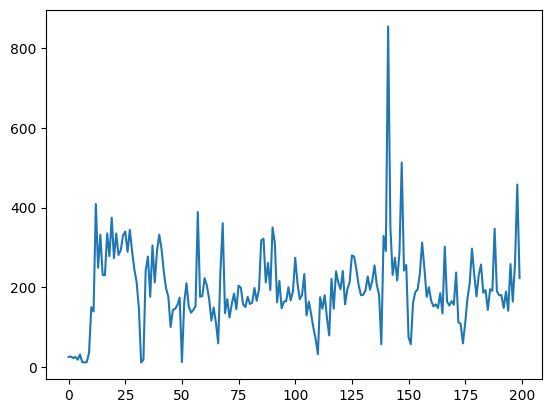

In [28]:
# The agent has been trained uncomment to train again
env = gym.make('CartPole-v1')
agent = Agent(env.observation_space.shape[0], env.action_space.n)
train(env, agent)
env.close()

In [30]:
import pickle
filename_load = '5 - DRL_200_v2.txt'

env = gym.make('CartPole-v1', render_mode='human')

agent = Agent(env.observation_space.shape[0], env.action_space.n)
file_open = open(filename_load, 'rb')
agent.model = pickle.load(file_open)
file_open.close()
done = False
while_count = 0

for episode in range(5):
    state, _ = env.reset()
    done = False
    while not done:
        env.render()
        action = agent.act_optimal(state)
        next_state, reward, done, _, _ = env.step(action)
        state = next_state
        while_count+=1
env.close()

## Optional (highly recommended): Atari
Adapt your agent to play an Atari game of your choice.
https://www.gymlibrary.dev/environments/atari/air_raid/